In [1]:
import datetime
import pyaurorax
import cartopy.crs

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

# Multi-network mosaics

It is also possible to make a mosaic that has several instrument arrays on it, displaying THEMIS ASI, TREx RGB, and others on a single map. 

Let's have a look at an example of a mosaic including TREx RGB, REGO, and THEMIS.

### Step 1: Download and read data

In [2]:
# keep imagers with data at different altitudes separate
data_list_110km = []
data_list_230km = []

# set the timestamp we're interested in
dt = datetime.datetime(2023, 2, 24, 6, 15)

# download the minute of RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
rgb_site_uid_list = ["yknf", "gill", "rabb", "luck"]
data_download_objs = {}
for site_uid in rgb_site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, dt, dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# read in the TREx RGB data site-by-site (we need this separation for mosaicing)
for site_uid, download_obj in data_download_objs.items():
    data_list_110km.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

# download the minute of THEMIS data from several sites
dataset_name = "THEMIS_ASI_RAW"
themis_site_uid_list = ["fsmi", "atha"]
data_download_objs = {}
for site_uid in themis_site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, dt, dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# read in and append to the SAME data_list
for site_uid, download_obj in data_download_objs.items():
    data_list_110km.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

# download the minute of REGO data
dataset_name = "REGO_RAW"
rego_site_uid_list = ["rank"]
data_download_objs = {}
for site_uid in rego_site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, dt, dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# read in and append to the SAME data_list
for site_uid, download_obj in data_download_objs.items():
    data_list_230km.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

### Step 2: Download and read skymaps

In [3]:
# initialize our total skymap data lists separately for imagers with data at different altitudes
skymaps_110km = []
skymaps_230km = []

# get the recommended skymap for RGB data, read it in
for site_uid in rgb_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("TREX_RGB_SKYMAP_IDLSAV", site_uid, dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps_110km.append(skymap.data[0])

# get the recommended skymap for THEMIS data, read it in
skymap_download_objs = {}
for site_uid in themis_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("THEMIS_ASI_SKYMAP_IDLSAV", site_uid, dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps_110km.append(skymap.data[0])

# get the recommended skymap for THEMIS data, read it in
skymap_download_objs = {}
for site_uid in rego_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("REGO_SKYMAP_IDLSAV", site_uid, dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps_230km.append(skymap.data[0])

### Step 3: Prep image and skymap data

In [4]:
# prepare the skymap data separately for THEMIS and TREX RGB, and REGO, since they're
# at different altitudes
prepped_skymap_110km = at.mosaic.prep_skymaps(skymaps_110km, 110, n_parallel=5)
prepped_skymap_230km = at.mosaic.prep_skymaps(skymaps_230km, 230)

Preparing skymaps:   0%|          | 0/6 [00:00<?, ?skymap/s]

Preparing skymaps:   0%|          | 0/1 [00:00<?, ?skymap/s]

In [5]:
# prepare the image data
prepped_images_110km = at.mosaic.prep_images(data_list_110km)
prepped_images_230km = at.mosaic.prep_images(data_list_230km)

### Step 4: Generate the mosaic

In [6]:
# define the intensity scales for each site
scale = {
    # RGB sites
    "yknf": (10, 105),
    "gill": (10, 105),
    "rabb": (10, 105),
    "luck": (10, 105),

    # THEMIS sites
    "atha": (3500, 14000),
    "fsmi": (3500, 14000),

    # REGO site
    "rank": (250, 1500),
}

# set timestamp to actually create mosaic frame for
mosaic_dt = datetime.datetime(2023, 2, 24, 6, 15, 3)

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create lists for inputs - all in same order, of which plotting will occur
prepped_images_list = [prepped_images_230km, prepped_images_110km]
prepped_skymap_list = [prepped_skymap_230km, prepped_skymap_110km]
min_elevation_list = [10, 5]

# create mosaic
mosaic = at.mosaic.create(prepped_images_list,
                          prepped_skymap_list,
                          mosaic_dt,
                          projection_obj,
                          image_intensity_scales=scale,
                          colormap=["gist_heat", "gray"],
                          min_elevation=min_elevation_list)
print(mosaic)

Mosaic(polygon_data=[PolyCollection(...), ...], cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


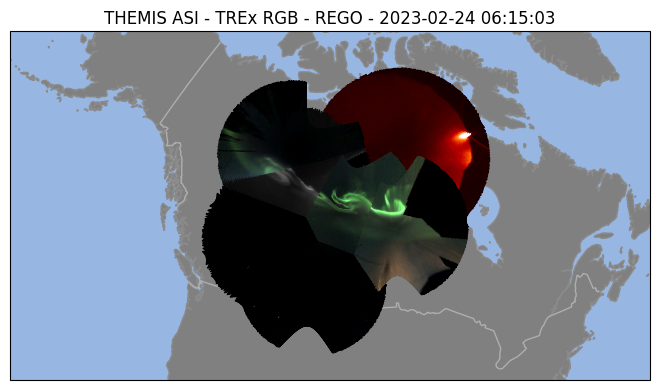

In [7]:
# plot the mosaic
map_extent = [-145, -65, 35, 70]
mosaic.plot(map_extent, title="THEMIS ASI - TREx RGB - REGO - %s" % (mosaic_dt.strftime("%Y-%m-%d %H:%M:%S")))

**NOTE**

In practice, it is not really useful to mask between REGO and THEMIS/RGB. Due to REGO's narrow band nature, the imagers are not looking at the same thing.

We do it here as just an example.